<a href="https://www.kaggle.com/code/jakubwalczykowski/chihuahua-vs-muffin-round1?scriptVersionId=122503932" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import os
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
train_dir='/kaggle/input/muffin-vs-chihuahua-image-classification/train'
test_dir='/kaggle/input/muffin-vs-chihuahua-image-classification/test'


class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)
print("{:15} : {}".format("Class Names", class_names))
print("{:15} : {}".format("No. of Classes", n_classes))

Class Names     : ['chihuahua', 'muffin']
No. of Classes  : 2


# 1. Loading Datases 

In [3]:
train_set = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    seed=42,
    batch_size=32,
    labels='inferred',
    label_mode='int',
    shuffle=True,
    image_size=(256, 256),
    subset="training")

val_set = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    seed=42,
    batch_size=32,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    subset="validation")


test_set = image_dataset_from_directory(
    test_dir,
    batch_size=32,
    seed=42,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256))


Found 4733 files belonging to 2 classes.
Using 3787 files for training.
Found 4733 files belonging to 2 classes.
Using 946 files for validation.
Found 1184 files belonging to 2 classes.


# 2. Content visualisation

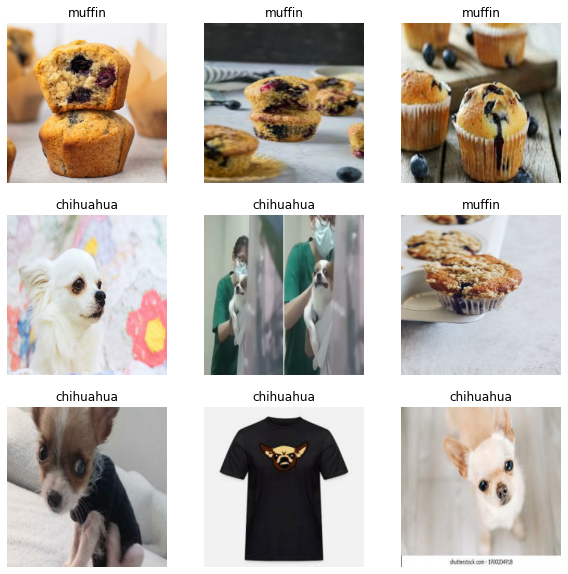

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
class_names = train_set.class_names
print(class_names)

['chihuahua', 'muffin']


# 3. Tuning and rescaling

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set= test_set.cache().prefetch(buffer_size=AUTOTUNE)


In [7]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [8]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)>

In [9]:
print(image_batch)

tf.Tensor(
[[[[0.9390967  0.66392046 0.4167085 ]
   [0.87328786 0.653719   0.4170037 ]
   [0.82388395 0.67745686 0.45055187]
   ...
   [0.73810476 0.3783639  0.18652105]
   [0.5986669  0.23047951 0.04112878]
   [0.78457373 0.41955376 0.21599099]]

  [[0.8690398  0.6337122  0.36509588]
   [0.83428687 0.639096   0.38719648]
   [0.80931485 0.6721989  0.4334198 ]
   ...
   [0.7392901  0.39976802 0.2015986 ]
   [0.69808567 0.35273203 0.15379184]
   [0.7288059  0.38790926 0.1718505 ]]

  [[0.8606556  0.66368866 0.38165742]
   [0.8378326  0.6698048  0.40385592]
   [0.8890078  0.75924486 0.5097828 ]
   ...
   [0.64022446 0.31891623 0.10607154]
   [0.7196319  0.39883134 0.18338032]
   [0.7478963  0.43050966 0.19918704]]

  ...

  [[0.9373545  0.8902957  0.79617804]
   [0.93176323 0.8847044  0.79058677]
   [0.9356939  0.88863504 0.7945174 ]
   ...
   [0.9448377  0.9213083  0.83037984]
   [0.94425774 0.9207283  0.8266107 ]
   [0.9409161  0.9173867  0.82326907]]

  [[0.9254025  0.8783437  0.776382

# 4. Model preparation

In [10]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ])

In [11]:
model = Sequential([
    data_augmentation,
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    GlobalMaxPooling2D(),
    Flatten(),
    Dense(512,activation='relu'),
    Dropout(0.2),
    Dense(1024,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')

])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [12]:

save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/model.h5', monitor='val_loss',mode='min',
save_best_only=True,
verbose=1)


In [13]:
epochs=50

history = model.fit(
  train_set,
  validation_data=val_set,
  epochs=epochs,
  callbacks=[save_checkpoint]
)


Epoch 1/50
119/119 [==============================] - 29s 162ms/step - loss: 0.7337 - accuracy: 0.7378 - val_loss: 1.4169 - val_accuracy: 0.5698

Epoch 00001: val_loss improved from inf to 1.41695, saving model to /content/drive/MyDrive/model.h5
Epoch 2/50
119/119 [==============================] - 12s 101ms/step - loss: 0.3955 - accuracy: 0.8302 - val_loss: 0.5689 - val_accuracy: 0.7051

Epoch 00002: val_loss improved from 1.41695 to 0.56890, saving model to /content/drive/MyDrive/model.h5
Epoch 3/50
119/119 [==============================] - 12s 102ms/step - loss: 0.3511 - accuracy: 0.8524 - val_loss: 0.5620 - val_accuracy: 0.7030

Epoch 00003: val_loss improved from 0.56890 to 0.56199, saving model to /content/drive/MyDrive/model.h5
Epoch 4/50
119/119 [==============================] - 12s 101ms/step - loss: 0.3238 - accuracy: 0.8693 - val_loss: 1.0774 - val_accuracy: 0.5370

Epoch 00004: val_loss did not improve from 0.56199
Epoch 5/50
119/119 [==============================] - 12s

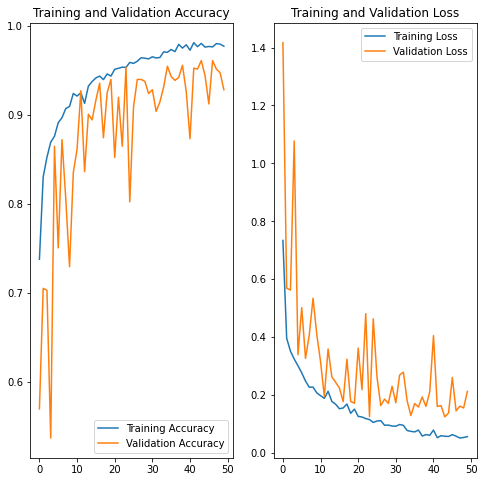

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [15]:
from keras.models import load_model

# 5. Loading best model and validation on test dataset.

In [16]:
reconstructed_model = keras.models.load_model('/content/drive/MyDrive/model.h5')

In [17]:
score = reconstructed_model.evaluate(val_set, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.12393581122159958
Val accuracy: 0.9608879685401917


In [18]:
score = reconstructed_model.evaluate(test_set, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16080856323242188
Test accuracy: 0.9476351141929626




Thank you, feedback is highly appreciated! :)

Please upvote if you found this helpful 👍
